# Predicting Future Hall of Fame Induction

## Team
- Roshun Tiwari
- Jake Ashkenase
- Suhaib Iqbal
- Tanay Kommareddi

## Abstract

This project attempts to correctly predict which MLB players are in the Hall of Fame based on their career stats and the awards they have won. We scraped data from [baseball-reference](https://www.baseball-reference.com) which gave us not only data on a player's career stats and awards, but also data on which players have ever been on a Hall of Fame ballot and who got accepted. Using this information, we created a [set of players](#data) that had a combination of inducted Hall of Famers and players who were on a ballot, meaning they have careers comparable to those in the Hall of Fame. We then created both a K nearest neighbor and random forest [machine learning](#ML) algorithm to try and predict which players would make the Hall of Fame given their stats and awards. Once we found the optimal machine learning model, we applied it to players who recently retirec in order to [predict](#pred) whether they would make the Hall of Fame or not. By assessing our [results](#results) we were able to understand how much of the decision to elect a player into the Hall of Fame is based on their stats and awards and how much of the decision comes from external factors.   

## Introduction

In 2021, the MLB closed in on its 20,000th player after nearly 150 years of existence. Of these twenty-thousand players, only a select few of the greatest and most successful individuals achieve hall of fame status- in fact, only about 1.2% of players. This project aims to use data scraped from the baseball-reference website in order to understand what qualifies an MLB player for entrance into the hall of fame. Using a collection of statistics from former MLB players already inducted into the hall of fame as well as those who have not been, we will explore and attempt to answer the question of whether or not we can predict a retired player will be inducted. Furthermore, we will attempt to answer which statistics play the biggest role into being inducted. To solve our questions, we will search for patterns and trends in the data that possibly point to a certain player being qualified to entering the hall of fame or that show a certain statistic being very important towards a player's chances.

With the historical data given, we can use Classification methods to analyze what performance stats lead to a Hall of Fame induction. With k-Nearest Neighbors, we can simply find k players with a similar career performance and identify if the majority of them made the Hall of Fame. With Random Forest, we can identify which performance stats are the most important in a player's Hall of Fame candidacy, and predict a player's election accordingly. In our project, we will go through both methods and identify which is better at predicting a player's Hall of Fame chances.

## Data 

### Overview 
Our data will come from a source called [baseball-reference](https://www.baseball-reference.com) which contains all past and present baseball data available. Through this site we will be able to scrape different pages in order to get different pieces of information about players. Everything from a player's career statistics to the amount of awards they won will be provided by this site. 


Some of the data we will be collecting and using for our project includes :
- Player Name
- Career Stats (at-bats, hits, batting average, games played, and much more)
-  Position 
-  Career awards (MVPS, Cy-Youngs, All star appearances, Gold Gloves, Silver Sluggers)

We will be getting our list of Hall of Fame players from one page on the website, and then the rest of our players (non Hall of Fame players to compare with) come from searching each individual player. The reason we want to search for individual players is because we want players who were on the Hall of Fame ballet, or who got close to the Hall of Fame, but never got actually inducted. Because of this, we would scrape a separate page on baseball reference to get the list of players who were on the ballet and then use that to find the stats for each of those individual players. One of the biggest challenges we will face is filtering players with the same name- fortunately, baseball reference includes a number such as '01' after duplicate player names, which we can use to our advantage when gathering their stats. 

Additionally, when it comes to collecting recently retired players for our final prediction step, we will use [Baseball Almanac](https://www.baseball-almanac.com/yearly/final.php?l=AL&y=2019) to find all players who have retired since 2017. Since Baseball Almanac restricts webscraping, we simply collected this small number of players manually. After, we created a DataFrame using the same functions we used for the historical data to find the career statistics of all these recent retirees.


### Pipeline Overview

We will accomplish this task with the following functions:

#### Webscraping and Formatting Data
- `get_player_table()`
    - Gets a DataFrame of the player's stats
    - Uses `get_pitcher_table()` and `get_batter_table()` as helper functions
- `get_pitcher_table()`
    - Gets a DataFrame of the pitcher's stats
- `get_batter_table()`
    - Gets a DataFrame of the batter's stats
- `get_awards()`
    - Returns a dictionary with a count of how many awards a player has one
    - Helper function for `get_pitcher_table()` and `get_batter_table()`
- `get_pos()`
    - Returns the position of the player
    - Helper function for `get_batter_table()`
- `ballot_players_new()`
    - returns a dataframe of all players on a Hall of Fame ballot 
    - focused on scraping from the new format of baseball reference pages
- `ballot_players_old()`
    - returns a dataframe of all players on a Hall of Fame ballot 
    - focused on scraping from the old format of baseball reference pages
- `clean_non_hof()`
    - returns a list of players who did not make the HOF but were on the ballot
    - takes in the dataframe from the above functions to do make the list

# Pipeline:

In [3]:
# all Libraries to be used 
import pandas as pd
import time
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from copy import copy
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score




import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

First, we find all the hall of fame players who were inducted since 1977

In [18]:
hof_inductees = pd.read_html('https://www.baseball-reference.com/awards/hof.shtml')[0]
s_bool = hof_inductees['Inducted As'] == 'Player'
hof_inductees = hof_inductees.loc[s_bool, :]
s_bool = hof_inductees['Voted By'] == 'BBWAA'
hof_inductees = hof_inductees.loc[s_bool, :]
list_inductees = hof_inductees.loc[:, 'Name']
list_inductees_temp = list_inductees[0:80]
list_inductees_temp

6 David Ortiz
7 Derek Jeter
10 Larry Walker
12 Roy Halladay
13 Edgar Martinez
 ... 
167 Al Kaline
169 Duke Snider
172 Willie Mays
176 Eddie Mathews
177 Ernie Banks
Name: Name, Length: 80, dtype: object

Below, we create 2 DataFrames: One for the career stats of every Hall of Fame pitcher, and one for the career stats of every Hall of Fame batter.

In [19]:
df_hof_p = pd.DataFrame()
df_hof_b = pd.DataFrame()

for player in list_inductees_temp:
    time.sleep(6)
    player_series = get_player_table(player)
    if len(list(player_series)) > 40:
        df_hof_p = df_hof_p.append(player_series)
    if len(list(player_series)) < 40:
        df_hof_b = df_hof_b.append(player_series)

df_hof_p['HOF'] = 1
df_hof_p

df_hof_b['HOF'] = 1
df_hof_b

David Ortiz
Derek Jeter
Larry Walker
Roy Halladay
Edgar Martinez
Mike Mussina
Mariano Rivera
Vladimir Guerrero
Trevor Hoffman
Chipper Jones
Jim Thome
Jeff Bagwell
Tim Raines
Ivan Rodriguez
Ken Griffey Jr.
Mike Piazza
Craig Biggio
Randy Johnson
Pedro Martinez
John Smoltz
Tom Glavine
Greg Maddux
Frank Thomas
Barry Larkin
Roberto Alomar
Bert Blyleven
Andre Dawson
Rickey Henderson
Jim Rice
Rich Gossage
Tony Gwynn
Cal Ripken Jr.
Bruce Sutter
Wade Boggs
Ryne Sandberg
Dennis Eckersley
Paul Molitor
Gary Carter
Eddie Murray
Ozzie Smith
Kirby Puckett
Dave Winfield
Carlton Fisk
Tony Perez
George Brett
Nolan Ryan
Robin Yount
Don Sutton
Phil Niekro
Mike Schmidt
Steve Carlton
Reggie Jackson
Rollie Fingers
Tom Seaver
Rod Carew
Fergie Jenkins
Gaylord Perry
Joe Morgan
Jim Palmer
Johnny Bench
Carl Yastrzemski
Willie Stargell
Catfish Hunter
Billy Williams
Willie McCovey
Lou Brock
Hoyt Wilhelm
Luis Aparicio
Don Drysdale
Harmon Killebrew
Juan Marichal
Brooks Robinson
Henry Aaron
Frank Robinson
Bob Gibson
A

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


,G,PA,AB,R,H,2B,3B,HR,RBI,SB,...,Pos,Awards,MVP,CYA,AS,GG,SS,Player,Unnamed: 30,HOF
29,2408,10091,8640,1419,2472,632,19,541,1768,17,...,1B,NaN,0.0,0.0,10.0,0.0,7.0,David Ortiz,NaN,1
29,2747,12602,11195,1923,3465,544,66,260,1311,358,...,SS,NaN,0.0,0.0,14.0,5.0,5.0,Derek Jeter,NaN,1
25,1988,8030,6907,1355,2160,471,62,383,1311,230,...,RF,NaN,1.0,0.0,5.0,7.0,3.0,Larry Walker,NaN,1
26,2055,8674,7213,1219,2247,514,15,309,1261,49,...,3B,NaN,0.0,0.0,7.0,0.0,5.0,Edgar Martinez,NaN,1
24,2147.0,9059.0,8155.0,1328.0,2590.0,477.0,46.0,449.0,1496.0,181.0,...,RF,NaN,1.0,0.0,9.0,0.0,8.0,Vladimir Guerrero,NaN,1
29,2499,10614,8984,1619,2726,549,38,468,1623,150,...,3B,NaN,1.0,0.0,8.0,0.0,2.0,Chipper Jones,NaN,1
36,2543,10313,8422,1583,2328,451,26,612,1699,19,...,1B,NaN,0.0,0.0,5.0,0.0,1.0,Jim Thome,NaN,1
19,2150,9431,7797,1517,2314,488,32,449,1529,202,...,1B,NaN,1.0,0.0,4.0,1.0,3.0,Jeff Bagwell,NaN,1
31,2543,10270,9592,1354,2844,572,51,311,1332,127,...,C,NaN,1.0,0.0,14.0,13.0,7.0,Ivan Rodriguez,NaN,1
27,2671,11304,9801,1662,2781,524,38,630,1836,184,...,CF,NaN,1.0,0.0,13.0,10.0,7.0,Ken Griffey Jr.,NaN,1


Below, we retrieve all the players who were not elected but were still on the ballot (since 1977).

In [25]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# create list of ballot players from 1977 onward 
unclean_ballot_new = ballot_players_new(1977)
s_bool = unclean_ballot_new.loc[:, 'result'] != 'ELECTED'
df_new = unclean_ballot_new.loc[s_bool, :]
players = df_new.loc[:, 'name']


non_hof_players = list(players.unique())
non_hof_players

#Cleans data, and removes players with '.' in their name
real_players = []
for player in non_hof_players:
    player_clean = player.strip()
    if '.' not in player and '\'' not in player and len(player_clean.split(' ')) < 3:
        real_players.append(player_clean)

#Identifies all the ballot players who didn't make the Hall of Fame
real_non_hof_players = []
for player in real_players:
    if player in list_inductees_temp:
        pass
    else:
        real_non_hof_players.append(player)

real_non_hof_players

['Ernie Banks',
 'Eddie Mathews',
 'Gil Hodges',
 'Enos Slaughter',
 'Duke Snider',
 'Don Drysdale',
 'Nellie Fox',
 'Jim Bunning',
 'George Kell',
 'Richie Ashburn',
 'Red Schoendienst',
 'Lew Burdette',
 'Roger Maris',
 'Alvin Dark',
 'Harvey Kuenn',
 'Ted Kluszewski',
 'Mickey Vernon',
 'Walker Cooper',
 'Elston Howard',
 'Don Newcombe',
 'Don Larsen',
 'Roy Face',
 'Curt Flood',
 'Ken Boyer',
 'Bobby Thomson',
 'Del Crandall',
 'Harvey Haddix',
 'Vern Law',
 'Dick Groat',
 'Vic Wertz',
 'Bill White',
 'Camilo Pascual',
 'Johnny Podres',
 'Hoyt Wilhelm',
 'Maury Wills',
 'Bill Mazeroski',
 'Jim Maloney',
 'Clete Boyer',
 'Denny McLain',
 'Mudcat Grant',
 'Pedro Ramos',
 'Willie Mays',
 'Luis Aparicio',
 'Frank Howard',
 'Ron Perranoski',
 'Milt Pappas',
 'Johnny Callison',
 'Hal Lanier',
 'Chris Short',
 'Tommie Agee',
 'Bernie Allen',
 'Gene Alley',
 'Jim Beauchamp',
 'Bobby Bolin',
 'Ray Culp',
 'Fred Gladding',
 'Jerry May',
 'Jose Pagan',
 'Joe Pepitone',
 'Rich Reese',
 'Larry 

Below, we create 2 DataFrames: One for the career stats of every Non Hall of Fame pitcher, and one for the career stats of every Non Hall of Fame batter.

In [26]:
df_non_hof_p = pd.DataFrame()
df_non_hof_b = pd.DataFrame()

for player in real_non_hof_players:
    time.sleep(6)
    if player not in list_inductees_temp:
        player_series = get_player_table(player)
        if len(list(player_series)) > 40:
            df_non_hof_p = df_non_hof_p.append(player_series)
        if len(list(player_series)) < 40:
            df_non_hof_b = df_non_hof_b.append(player_series)
            
df_non_hof_p['HOF'] = 0

df_non_hof_b['HOF'] = 0

(     Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1       G       PA      AB  \
 0             0           0.0            21.0  2071.0   8104.0  7030.0   
 1             1           1.0            31.0  2380.0   9087.0  7946.0   
 2             2           2.0            24.0  2367.0  10351.0  9232.0   
 3             3           3.0            25.0  1795.0   7529.0  6702.0   
 4             4           4.0            18.0  2189.0   9737.0  8365.0   
 ..          ...           ...             ...     ...      ...     ...   
 437          22           NaN             NaN  1572.0   6531.0  5707.0   
 438          23           NaN             NaN  1862.0   8029.0  6936.0   
 439          26           NaN             NaN  1545.0   6392.0  5699.0   
 440          16           NaN             NaN  1611.0   6853.0  5821.0   
 441          25           NaN             NaN  1716.0   7178.0  6655.0   
 
           R       H     2B     3B  ...  Pos  Awards  Unnamed: 30  MVP  CYA  \
 0    1105.0  1921.

In [27]:
df_non_hof_b

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,G,PA,AB,R,H,2B,3B,...,Pos,Awards,Unnamed: 30,MVP,CYA,AS,GG,SS,Player,HOF
0,0,0.0,21.0,2071.0,8104.0,7030.0,1105.0,1921.0,295.0,48.0,...,1B,NaN,NaN,0,0,8,3,0,Gil Hodges,0
1,1,1.0,31.0,2380.0,9087.0,7946.0,1247.0,2383.0,413.0,148.0,...,RF,NaN,NaN,0,0,10,0,0,Enos Slaughter,0
2,2,2.0,24.0,2367.0,10351.0,9232.0,1279.0,2663.0,355.0,112.0,...,2B,NaN,NaN,1,0,15,3,0,Nellie Fox,0
3,3,3.0,25.0,1795.0,7529.0,6702.0,880.0,2054.0,385.0,50.0,...,3B,NaN,NaN,0,0,10,0,0,George Kell,0
4,4,4.0,18.0,2189.0,9737.0,8365.0,1322.0,2574.0,317.0,109.0,...,CF,NaN,NaN,0,0,6,0,0,Richie Ashburn,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,22,NaN,NaN,1572.0,6531.0,5707.0,848.0,1475.0,277.0,21.0,...,1B,NaN,NaN,1,0,3,0,1,Ryan Howard,0
438,23,NaN,NaN,1862.0,8029.0,6936.0,1099.0,1862.0,408.0,18.0,...,1B,NaN,NaN,0,0,3,5,3,Mark Teixeira,0
439,26,NaN,NaN,1545.0,6392.0,5699.0,772.0,1603.0,349.0,23.0,...,1B,NaN,NaN,1,0,4,0,2,Justin Morneau,0
440,16,NaN,NaN,1611.0,6853.0,5821.0,862.0,1645.0,321.0,10.0,...,1B,NaN,NaN,0,0,6,0,3,Prince Fielder,0


In [28]:
df_non_hof_p

,Unnamed: 0,Unnamed: 0.1,Year,Age,Tm,Lg,W,L,W-L%,ERA,...,Awards,Pos,MVP,CYA,AS,GG,SS,Player,Unnamed: 35,HOF
0,0,26.0,17 Yrs,17 Yrs,17 Yrs,17 Yrs,224.0,184.0,0.549,3.27,...,NaN,P,0,0,9,0,0,Jim Bunning,NaN,0
1,1,30.0,18 Yrs,18 Yrs,18 Yrs,18 Yrs,203.0,144.0,0.585,3.66,...,NaN,P,0,0,3,0,0,Lew Burdette,NaN,0
2,2,23.0,12 Yrs,12 Yrs,12 Yrs,12 Yrs,153.0,96.0,0.614,3.57,...,NaN,P,1,1,4,0,0,Don Newcombe,NaN,0
3,3,32.0,14 Yrs,14 Yrs,14 Yrs,14 Yrs,81.0,91.0,0.471,3.78,...,NaN,P,0,0,0,0,0,Don Larsen,NaN,0
4,4,25.0,16 Yrs,16 Yrs,16 Yrs,16 Yrs,104.0,95.0,0.523,3.48,...,NaN,P,0,0,6,0,0,Roy Face,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,22,NaN,13 Yrs,13 Yrs,13 Yrs,13 Yrs,153.0,131.0,0.539,3.75,...,NaN,P,0,0,3,0,0,Dan Haren,NaN,0
228,31,NaN,16 Yrs,16 Yrs,16 Yrs,16 Yrs,64.0,34.0,0.653,2.87,...,NaN,P,0,0,6,0,0,Joe Nathan,NaN,0
229,14,NaN,10 Yrs,10 Yrs,10 Yrs,10 Yrs,110.0,89.0,0.553,3.74,...,NaN,P,0,2,4,0,0,Tim Lincecum,NaN,0
230,18,NaN,12 Yrs,12 Yrs,12 Yrs,12 Yrs,41.0,36.0,0.532,2.44,...,NaN,P,0,0,6,0,0,Jonathan Papelbon,NaN,0


Combines all the Pitcher Data:
<a id='data'></a>

In [29]:
df_p = pd.DataFrame()
df_p = df_p.append(df_hof_p)
df_p = df_p.append(df_non_hof_p)
df_p = df_p.dropna(subset=['HOF'])
df_p

,Year,Age,Tm,Lg,W,L,W-L%,ERA,G,GS,...,MVP,CYA,AS,GG,SS,Player,Unnamed: 35,HOF,Unnamed: 0,Unnamed: 0.1
24,16 Yrs,16 Yrs,16 Yrs,16 Yrs,203.0,105.0,0.659,3.38,416.0,390.0,...,0.0,2.0,8.0,0.0,0.0,Roy Halladay,NaN,1,NaN,NaN
22,18 Yrs,18 Yrs,18 Yrs,18 Yrs,270,153,.638,3.68,537,536,...,0.0,0.0,5.0,7.0,0.0,Mike Mussina,NaN,1,NaN,NaN
26,19 Yrs,19 Yrs,19 Yrs,19 Yrs,82,60,.577,2.21,1115,10,...,0.0,0.0,13.0,0.0,0.0,Mariano Rivera,NaN,1,NaN,NaN
24,18 Yrs,18 Yrs,18 Yrs,18 Yrs,61,75,.449,2.87,1035,0,...,0.0,0.0,7.0,0.0,0.0,Trevor Hoffman,NaN,1,NaN,NaN
35,22 Yrs,22 Yrs,22 Yrs,22 Yrs,303,166,.646,3.29,618,603,...,0.0,5.0,10.0,0.0,0.0,Randy Johnson,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,13 Yrs,13 Yrs,13 Yrs,13 Yrs,153.0,131.0,0.539,3.75,391.0,380.0,...,0.0,0.0,3.0,0.0,0.0,Dan Haren,NaN,0,22.0,NaN
228,16 Yrs,16 Yrs,16 Yrs,16 Yrs,64.0,34.0,0.653,2.87,787.0,29.0,...,0.0,0.0,6.0,0.0,0.0,Joe Nathan,NaN,0,31.0,NaN
229,10 Yrs,10 Yrs,10 Yrs,10 Yrs,110.0,89.0,0.553,3.74,278.0,270.0,...,0.0,2.0,4.0,0.0,0.0,Tim Lincecum,NaN,0,14.0,NaN
230,12 Yrs,12 Yrs,12 Yrs,12 Yrs,41.0,36.0,0.532,2.44,689.0,3.0,...,0.0,0.0,6.0,0.0,0.0,Jonathan Papelbon,NaN,0,18.0,NaN


Combines all the Batter Data:

In [30]:
df_b = pd.DataFrame()
df_b = df_b.append(df_hof_b)
df_b = df_b.append(df_non_hof_b)
df_b = df_b.dropna(subset=['HOF'])
df_b

,G,PA,AB,R,H,2B,3B,HR,RBI,SB,...,CYA,AS,GG,SS,Player,Unnamed: 30,HOF,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1
29,2408,10091,8640,1419,2472,632,19,541,1768,17,...,0.0,10.0,0.0,7.0,David Ortiz,NaN,1,NaN,NaN,NaN
29,2747,12602,11195,1923,3465,544,66,260,1311,358,...,0.0,14.0,5.0,5.0,Derek Jeter,NaN,1,NaN,NaN,NaN
25,1988,8030,6907,1355,2160,471,62,383,1311,230,...,0.0,5.0,7.0,3.0,Larry Walker,NaN,1,NaN,NaN,NaN
26,2055,8674,7213,1219,2247,514,15,309,1261,49,...,0.0,7.0,0.0,5.0,Edgar Martinez,NaN,1,NaN,NaN,NaN
24,2147.0,9059.0,8155.0,1328.0,2590.0,477.0,46.0,449.0,1496.0,181.0,...,0.0,9.0,0.0,8.0,Vladimir Guerrero,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,1572.0,6531.0,5707.0,848.0,1475.0,277.0,21.0,382.0,1194.0,12.0,...,0.0,3.0,0.0,1.0,Ryan Howard,NaN,0,22.0,NaN,NaN
438,1862.0,8029.0,6936.0,1099.0,1862.0,408.0,18.0,409.0,1298.0,26.0,...,0.0,3.0,5.0,3.0,Mark Teixeira,NaN,0,23.0,NaN,NaN
439,1545.0,6392.0,5699.0,772.0,1603.0,349.0,23.0,247.0,985.0,5.0,...,0.0,4.0,0.0,2.0,Justin Morneau,NaN,0,26.0,NaN,NaN
440,1611.0,6853.0,5821.0,862.0,1645.0,321.0,10.0,319.0,1028.0,18.0,...,0.0,6.0,0.0,3.0,Prince Fielder,NaN,0,16.0,NaN,NaN


Note: We cannot merge the Pitcher Data with the Batter Data because pitchers and batters have different metrics, so it would be inappropriate to merge the two DataFrames. For example, Pitchers have a category describing their career ERA, but this is not a metric that Batters have.

Now, we will assemble the corresponding dataframes for the retirees/future nominees.

Again, we were unable to properly webscrape this portion due to Baseball Almanac's restriction against webscraping.

In [34]:
hof_nominees_list = ['Carlos Beltran', 'John Lackey', 'Jered Weaver', 'Jacoby Ellsbury',
                         'Matt Cain', 'Jhonny Peralta', 'Jayson Werth', 'J.J. Hardy', 'Mike Napoli',
                         'Bronson Arroyo', 'R.A. Dickey', 'Francisco Rodriguez', 'Andre Ethier',
                         'Huston Street',
                    'Adrian Beltre', 'Chase Utley', 'Joe Mauer', 'David Wright', 
                     'Matt Holliday', 'Adrian Gonzalez', 'Jose Reyes', 'Jose Bautista', 'Victor Martinez', 'Brandon Phillips', 
                     'Denard Span', 'Chase Headley', 'Colby Rasmus', 'Dustin Pedroia', 'CC Sabathia', 'Troy Tulowitzki',
                     'Ichiro Suzuki', 'Brian McCann', 'Ben Zobrist', 'Russell Martin', 'Curtis Granderson', 'Martin Prado',
                     'Carlos Gomez', 'Melky Cabrera', 'Ian Kinsler', 'Chris Davis', 'Gio Gonzalez', 'Alex Gordon', 
                     'Nick Markakis', 'Daniel Murphy', 'Ryan Braun', 'Hunter Pence', 'Howie Kendrick', 'Kyle Seager',
                     'Josh Reddick', 'Jordan Zimmermann', 'Todd Frazier', 'Jake Arrieta', 'Buster Posey', 'J.A. Happ',
                     'Jon Lester', 'Ryan Zimmerman', 'Yadier Molina', 'Albert Pujols']

In [31]:
df_nominees_b = pd.DataFrame()
df_nominees_p = pd.DataFrame()

for player in hof_nominees_list:
    time.sleep(20)
    player_series = get_player_table(player)
    if player_series.shape[0] > 40:
        df_nominees_p = df_nominees_p.append(player_series)
    else:
        df_nominees_b = df_nominees_b.append(player_series)

df_nominees_b = pd.get_dummies(df_nominees_b, columns=['Pos'])

In [32]:
df_nominees_b

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,G,PA,AB,R,H,2B,3B,...,Pos_1B,Pos_CF,Pos_RF,Pos_SS,Pos_C,Pos_2B,Pos_3B,Pos_LF,Unnamed: 30,Pos
0,0,0,35,2586.0,11031.0,9768.0,1582.0,2725.0,565.0,78.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1,18,1235.0,5375.0,4846.0,749.0,1376.0,241.0,47.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,2,24,1798.0,7319.0,6599.0,841.0,1761.0,376.0,24.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,3,3,32,1583.0,6366.0,5484.0,883.0,1465.0,300.0,22.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,4,23,1561.0,6309.0,5805.0,718.0,1488.0,291.0,14.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
5,5,5,25,1392.0,5330.0,4572.0,697.0,1125.0,224.0,11.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,6,6,20,1455.0,5425.0,4800.0,641.0,1367.0,303.0,34.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,7,7,26,2933.0,12130.0,11068.0,1524.0,3166.0,636.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
8,8,8,29,1937.0,7863.0,6857.0,1103.0,1885.0,411.0,58.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
9,9,9,24,1858.0,7960.0,6930.0,1018.0,2123.0,428.0,30.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [33]:
df_nominees_p

,Unnamed: 0,Year,Age,Tm,Lg,W,L,W-L%,ERA,G,...,SO9,SO/W,Awards,Pos,MVP,CYA,AS,GG,SS,Player
0,26,15 Yrs,15 Yrs,15 Yrs,15 Yrs,188.0,147.0,0.561,3.92,448.0,...,7.3,2.81,NaN,P,0.0,0.0,1.0,0.0,0.0,John Lackey
1,22,11 Yrs,11 Yrs,11 Yrs,11 Yrs,104.0,119.0,0.466,4.71,355.0,...,5.9,2.35,NaN,P,0.0,0.0,0.0,0.0,0.0,Jered Weaver
2,19,13 Yrs,13 Yrs,13 Yrs,13 Yrs,104.0,118.0,0.468,3.68,342.0,...,7.3,2.38,NaN,P,0.0,0.0,3.0,0.0,0.0,Matt Cain
3,27,16 Yrs,16 Yrs,16 Yrs,16 Yrs,148.0,137.0,0.519,4.28,419.0,...,5.8,2.38,NaN,P,0.0,0.0,1.0,1.0,0.0,Bronson Arroyo
4,31,15 Yrs,15 Yrs,15 Yrs,15 Yrs,120.0,118.0,0.504,4.04,400.0,...,6.4,2.23,NaN,P,0.0,1.0,1.0,1.0,0.0,R.A. Dickey
5,22,13 Yrs,13 Yrs,13 Yrs,13 Yrs,42.0,34.0,0.553,2.95,668.0,...,8.8,3.63,NaN,P,0.0,0.0,2.0,0.0,0.0,Huston Street
6,28,19 Yrs,19 Yrs,19 Yrs,19 Yrs,251.0,161.0,0.609,3.74,561.0,...,7.8,2.81,NaN,P,0.0,1.0,6.0,0.0,0.0,CC Sabathia
7,23,13 Yrs,13 Yrs,13 Yrs,13 Yrs,131.0,101.0,0.565,3.70,344.0,...,8.7,2.28,NaN,P,0.0,0.0,2.0,0.0,0.0,Gio Gonzalez
8,20,13 Yrs,13 Yrs,13 Yrs,13 Yrs,95.0,91.0,0.511,4.07,279.0,...,7.1,3.67,NaN,P,0.0,0.0,2.0,0.0,0.0,Jordan Zimmermann
9,22,12 Yrs,12 Yrs,12 Yrs,12 Yrs,115.0,93.0,0.553,3.98,285.0,...,8.0,2.51,NaN,P,0.0,1.0,1.0,0.0,1.0,Jake Arrieta


Below, we have players who share the same name with someone else in baseball history. We keep track since this will affect the url for webscraping.

In [17]:
duplicate_list_2 = ['Lee Smith', 'Jack Morris', 'Ken Griffey Jr.', 'Pedro Martinez', 'Tom Glavine', 'Eddie Murray', 'Joe Morgan',
                    'Frank Robinson', 'Jackie Robinson', 'Camilo Pascual',  'Clete Boyer', 'Chris Short', 'John Stephenson',
                    'Jim Hickman', 'Don McMahon', 'Mike Ryan', 'Johnny Briggs', 'Bob Locker', 
                    'Tommy Davis', 'Tony Taylor', 'Davey Johnson', 'Clay Carroll',
                    'George Scott', 'Jose Cardenal', 'Ross Grimsley', 'Bill Robinson',
                    'Roy Howell', 'Bill Campbell', 'Darrell Porter', 'Terry Kennedy',
                    'George Bell', 'Jack Morris', 'Willie Wilson', 'Lance Parrish',
                    'Lee Smith', 'Danny Jackson', 'Mitch Williams', 'Tony Phillips',
                    'Will Clark', 'Hal Morris', 'Mike Jackson', 'Tino Martinez',
                    'Marquis Grissom', 'Bobby Higginson', 'Bernie Williams', 'Vinny Castilla',
                    'Bill Mueller', 'Roger Clemens', 'Sandy Alomar', 'Reggie Sanders',
                    'Mike Stanton', 'Rondell White', 'Woody Williams', 'Todd Jones',
                    'Brian Giles', 'Tony Clark', 'Billy Wagner', 'Manny Ramirez',
                    'Derrek Lee', 'Johan Santana', 'Kerry Wood', 'Michael Young',
                    'Darren Oliver', 'Cliff Lee', 'Josh Beckett', 'Rafael Furcal',
                    'Carl Crawford', 'Jered Weaver', 'Jose Bautista', 'Chris Davis', 'Ryan Braun', 'Jordan Zimmermann']
duplicate_list_3 = ['Bill White', 'John Kennedy',  'Bill Lee', 'Mike Scott', 'Devon White',
                    'Juan Gonzalez', 'Freddy Garcia', 'Francisco Rodriguez', 'David Wright']
duplicate_list_4 = ['Frank Thomas', 'Bob Miller', 'Matt Williams', 'Charles Johnson',
                    'Todd Walker', ]
duplicate_list_5 = ['Randy Johnson', 'Dale Murphy', 'Tom Browning', 'Jacque Jones',
                    ]
duplicate_list_6 = ['Chipper Jones', 'Reggie Smith']
duplicate_list_8 = ['Daniel Murphy']

# Functions:

In [11]:
def get_player_table(player):
    ''' For a player, finds their career stats and amount of awards theyve won
    
    Args:
        player (str): name of the player
        
    Return:
        table (pd.DataFrame): A dataframe of their stats and awards'''
    print(player)
    player_first = player.split(' ')[0].replace('.', '')
    player_last = player.split(' ')[1]
    player_id = (player_last[0:5] + player_first[0:2]).lower()
    if player == 'CC Sabathia':
        player_id = 'sabatc.'
    if player == 'R.A. Dickey':
        player_id = 'dicker.'
    if player == 'Henry Aaron':
        player_id = 'aaronha'
    last_initial = player_id[0]
    number = '01'
    if player in duplicate_list_2:
        number = '02'
    if player in duplicate_list_3:
        number = '03'
    if player in duplicate_list_4:
        number = '04'
    if player in duplicate_list_5:
        number = '05'
    if player in duplicate_list_6:
        number = '06'
    if player in duplicate_list_8:
        number = '08'
    url = f'https://www.baseball-reference.com/players/{last_initial}/{player_id}{number}.shtml'
    reg_pd = pd.read_html(url)[0]
    if reg_pd.shape[1] > 34:
        return get_pitcher_table(player)
    if reg_pd.shape[1] < 34:
        return get_batter_table(player)

In [12]:
def get_pitcher_table(player):
    ''' For a pitcher, finds their career stats and amount of awards theyve won
    
    Args:
        player (str): name of the player
        
    Return:
        table (pd.DataFrame): A dataframe of their stats and awards'''
    player_first = player.split(' ')[0].replace('.', '')
    player_last = player.split(' ')[1]
    player_id = (player_last[0:5] + player_first[0:2]).lower()
    last_initial = player_id[0]
    number = '01'
    if player == 'R.A. Dickey':
        player_id = 'dicker.'
    if player == 'CC Sabathia':
        player_id = 'sabatc.'
    if player in duplicate_list_2:
        number = '02'
    if player in duplicate_list_3:
        number = '03'
    if player in duplicate_list_4:
        number = '04'
    if player in duplicate_list_5:
        number = '05'
    if player in duplicate_list_6:
        number = '06'
    if player in duplicate_list_8:
        number = '08'
    url = f'https://www.baseball-reference.com/players/{last_initial}/{player_id}{number}.shtml'
    url_post = f'https://www.baseball-reference.com/players/gl.fcgi?id={player_id}{number}&t=p&post=1'
    reg_pd = pd.read_html(url)[0]
    first_year = float(reg_pd.loc[0, 'Year'])
    if first_year < 1980:
        return pd.DataFrame()
    rows = reg_pd.shape[0]
    reg_pd = reg_pd.dropna(subset=['Age', 'FIP'])
    awards_list = reg_pd.loc[:, 'Awards']
    awards_count_dict = get_awards(awards_list)
    year_col = list(reg_pd.loc[:, 'Year'])
    for idx in range(0, len(year_col)):
        entry = year_col[idx]
        if str(entry).split(' ')[-1] == 'Yrs':
            row_idx = idx
            break

    player_career_df = reg_pd.iloc[row_idx, :]
    player_career_df['Pos'] = 'P'
    for key in awards_count_dict.keys():
        player_career_df[key] = awards_count_dict[key]

    player_career_df['Player'] = player
    return player_career_df
    

In [13]:
def get_batter_table(player):
    ''' For a batter, finds their career stats and amount of awards theyve won
    
    Args:
        player (str): name of the player
        
    Return:
        table (pd.DataFrame): A dataframe of their stats and awards'''

    player_first = player.split(' ')[0].replace('.', '')
    player_last = player.split(' ')[1]
    player_id = (player_last[0:5] + player_first[0:2]).lower()
    last_initial = player_id[0]
    if player == 'Henry Aaron':
        player_id = 'aaronha'
    number = '01'
    if player in duplicate_list_2:
        number = '02'
    if player in duplicate_list_3:
        number = '03'
    if player in duplicate_list_4:
        number = '04'
    if player in duplicate_list_5:
        number = '05'
    if player in duplicate_list_6:
        number = '06'
    if player in duplicate_list_8:
        number = '08'
    url = f'https://www.baseball-reference.com/players/{last_initial}/{player_id}{number}.shtml'
    url_post = f'https://www.baseball-reference.com/players/gl.fcgi?id={player_id}{number}&t=b&post=1'
    reg_pd = pd.read_html(url)[0]
    first_year = float(reg_pd.loc[0, 'Year'])
    if first_year < 1980:
        return pd.DataFrame()
    year_one = reg_pd.loc[0, 'Year']
    rows = reg_pd.shape[0]
    reg_pd = reg_pd.dropna(subset=['OPS+'])
    reg_pd = reg_pd.replace('Did not play in major or minor leagues (Military Service)', np.nan)
    awards_list = reg_pd.loc[:, 'Awards']
    awards_count_dict = get_awards(awards_list)
    year_col = list(reg_pd.loc[:, 'Year'])
    #print(year_col)
    for idx in range(0, len(year_col)):
        #print(idx)
        entry = year_col[idx]
        if str(entry).split(' ')[-1] == 'Yrs':
            row_idx = idx
            break
    player_career_df = reg_pd.iloc[row_idx, :]
    pos_list = reg_pd.loc[:, 'Pos']
    pos = get_pos(pos_list)
    player_career_df['Pos'] = pos
    for key in awards_count_dict.keys():
        player_career_df[key] = awards_count_dict[key]

    player_career_df['Player'] = player
    return player_career_df[4:]
    
    

In [14]:
def get_awards(awards_list):
    ''' Given a list of awards, identifies the counts of mvps, cy youngs, all stars, gold gloves, and silver sluggers
    
    Args:
        awards_list (list): list of awards
        
    Returns:
        awards_count (dict): A dict which represents the number of mvps, cy youngs, all stars, ggs, and ss'''

    mvp_count = 0
    cya_count = 0
    as_count = 0
    gg_count = 0
    ss_count = 0

    for awards in awards_list:
        awards_str = str(awards)
        awards_split = awards_str.split(',')
        for award in awards_split:
            if award == 'MVP-1':
                mvp_count += 1
            if award == 'CYA-1':
                cya_count += 1
            if award == 'AS':
                as_count += 1
            if award == 'GG':
                gg_count += 1
            if award == 'SS':
                ss_count += 1

    awards_count = {'MVP': mvp_count, 'CYA': cya_count, 'AS': as_count, 'GG': gg_count, 'SS': ss_count}
    return awards_count

In [15]:
def get_pos(pos_list):
    ''' Given a list of positions over the years, identifies which position the player played the most over the years
    
    Args:
        pos_list (list): A list of the players positions they played per year
        
    Return:
        pos (str): A string which represents the position they played'''

    corresponding_pos = {'1': 'P', '2': 'C', '3': '1B', '4': '2B', '5': '3B',
                         '6': 'SS', '7': 'LF', '8': 'CF', '9': 'RF', 'D': 'DH'}

    pos_count = defaultdict(lambda: 0)

    for year_pos in pos_list:
        year_pos_str = str(year_pos)
        pos_main = year_pos_str.split('/')[0].replace('*', '').replace('\n', '').replace('NaN', '')
        for pos in pos_main:
            if str(pos).lower() in list(corresponding_pos.keys()):
                pos_count[pos] += 1

    pos_count_dict = dict(pos_count)
    max_pos = max(pos_count_dict, key=pos_count_dict.get)
    pos = corresponding_pos[max_pos]
    return pos
    
    
        

In [21]:
def ballot_players_new(start_year):
    ''' finds all players on the Hall of Fame ballot who didn't get in 
    
    Args:
        - start_year (int): year to start pulling players from
    
    Returns:
        - ballot_list (list): a list of all player names who were on the HOF ballot 
   
    '''
    # create an empty list for all of the data
    all_players = []

    # go through years starting from the given date till current (2022)
    for year in range(start_year, 2023):
        year = str(year)

        url = f'https://www.baseball-reference.com/bullpen/{year}_Hall_of_Fame_Election'
        str_html = requests.get(url).text
        soup = BeautifulSoup(str_html)

        tr_all = soup.find_all('tr')

        for i in range(1, (len(tr_all) - 2)):

            # find the text in the soup
            info = tr_all[i].text

            # clean it into lists for each player
            split_info = info.replace("\n", " ")
            split_info = split_info.strip()
            split_info = split_info.split(" ")

            # check to see if the end of the table has been reached
            if split_info[0] == "Player":
                break
            if split_info[0] == "National":
                break

            # deal with the case of a player having 3 names 
            # in the cases where they dont have a third name the third column will be an int or an empty string
            # in either cases the following will allow for players with three names to have their full name displayed
            try:
                int(split_info[2])
                third_name = ""
            except ValueError:
                third_name = split_info[2]

            # record a players information and append a list of their info to another list
            first_name = split_info[0]
            last_name = split_info[1]
            result = split_info[-1]

            all_players.append([first_name + " " + last_name + " " + third_name, result])

    new_df = pd.DataFrame(all_players, columns=["name", "result"])
    return new_df

In [22]:
def ballot_players_old(end_year):
    ''' finds all players on the Hall of Fame ballot who didn't get in 
    
    Args:
        - end_year (int): year to stop pulling players from
    
    Returns:
        - ballot_list (list): a list of all player names who were on the HOF ballot 
   
    '''
    # create an empty list for all of the data
    all_players = []

    # go through years starting from the first HOF induction to the specified end year
    for year in range(1936, (end_year + 1)):
        year = str(year)

        url = f'https://www.baseball-reference.com/bullpen/{year}_Hall_of_Fame_Election'
        str_html = requests.get(url).text
        soup = BeautifulSoup(str_html)

        tr_all = soup.find_all('tr')

        for i in range(1, (len(tr_all) - 2)):
            # find the text in the soup
            info = tr_all[i].text

            # clean it into lists for each player
            split_info = info.replace("\n", " ")
            split_info = split_info.strip()
            split_info = split_info.split(" ")

            # check to see if the end of the table has been reached 
            if split_info[0] == "Player":
                break
            if split_info[0] == "National":
                break

            # deal with the case of a player having 3 names 
            # in the cases where they dont have a third name the third column will be an int or an empty string
            # in either cases the following will allow for players with three names to have their full name displayed
            try:
                int(split_info[2])
                third_name = ""
            except ValueError:
                third_name = split_info[2]

            # record a players information and append a list of their info to another list
            first_name = split_info[0]
            last_name = split_info[1]
            result = split_info[-1]

            all_players.append([first_name + " " + last_name + " " + third_name, result])

    old_df = pd.DataFrame(all_players, columns=["name", "result"])
    return old_df
            

In [23]:
def clean_non_hof(df):
    """ takes a dataframe of players and gets rid of players who were elected into the hall of fame 
    
    param: a dataframe of players who were on the hall of fame ballot
    
    returns: a list of players not inducted in the hall of fame 
    
    """
    # list for hall of famers
    elected_list = []

    # find all hall of famers and append them to a list
    for index in df.index:
        if str(df["result"][index]).lower() == "elected":
            elected_list.append(df["name"][index])

    # group by name and reset index 
    all = list(set(df["name"]))
    non_hof = [player for player in all if player not in elected_list]
    return non_hof

# Visuals:

# Visual 1:

This visual, we'd like to compare the ERAs of pitchers who made the Hall of Fame, and pitchers who did not make the Hall of Fame.

Text(0.5, 0.98, 'Histogram of ERA for HOF and Non HOF Pitchers')

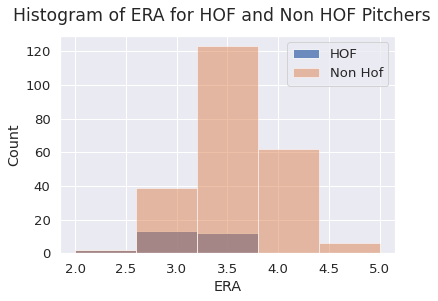

In [48]:
bins = np.linspace(2, 5, 6)

df_hof_p = pd.read_csv('df_hof_p.csv')
df_non_hof_p = pd.read_csv('df_non_hof_p.csv')

plt.hist(df_hof_p.loc[:, 'ERA'], bins=bins, alpha=0.8)
plt.hist(df_non_hof_p.loc[:, 'ERA'], bins=bins, alpha=0.5)
plt.legend(labels=['HOF', 'Non Hof'])
plt.xlabel('ERA')
plt.ylabel('Count')
plt.suptitle('Histogram of ERA for HOF and Non HOF Pitchers')

### Analysis:

We can see from the above graph that pitchers who made the hall of fame tend to have lower ERAs than those who did not make the hall of fame. This is what we expected, since a low ERA means that a pitcher is more successful, so it makes sense that pitchers with lower ERAs are in the hall of fame.

This will be important to know for our Machine Learning analysis in the coming weeks, since we can expect ERA to be a feature with a relatively high importance in our models because it helps separate the two classes of pitchers (even if there is some small overlap).

## Visual 2:

Next, we'd like to examine how many of each award a player received based on their position. When it comes to the Hall of Fame, position is an important factor, since voters will compare a player not necessarily to all players already in the Hall of Fame, but more precisely with other players at that same position who are already in the Hall of Fame. We'd like to see if some positions have more success at winning certain awards than others.

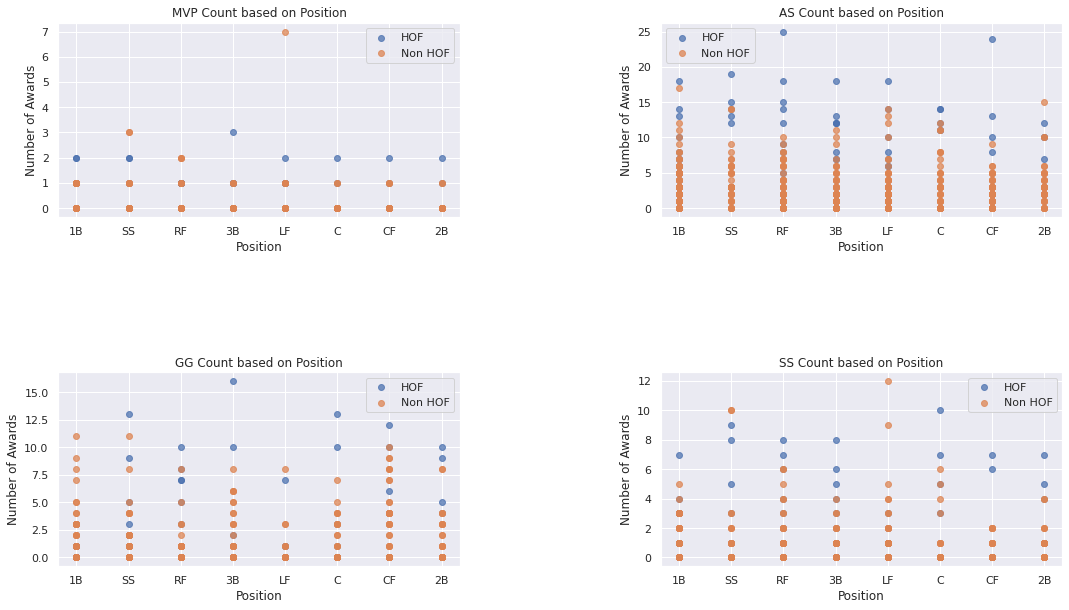

In [169]:

df_hof_b = pd.read_csv('df_hof_b.csv')
df_non_hof_b = pd.read_csv('df_non_hof_b.csv')

awards = ['MVP', 'AS', 'GG', 'SS']

for idx in range(0, 4):
    award = awards[idx]
    plt.subplot(2, 2, idx + 1)
    
    plt.scatter(df_hof_b.loc[:, 'Pos'], df_hof_b.loc[:, award], alpha=0.75)
    plt.scatter(df_non_hof_b.loc[:, 'Pos'], df_non_hof_b.loc[:, award], alpha=0.75)
    
    plt.legend(labels=['HOF', 'Non HOF'])
    
    plt.xlabel('Position')
    plt.ylabel('Number of Awards')
    plt.gca().title.set_text(award + ' Count based on Position' ) 
    

plt.gcf().set_size_inches(18, 10)
plt.subplots_adjust(wspace=.5, hspace=0.8) 

# Method:

We choose to use a K nearest neighbor algorithm in order to check if a player making the hall of fame can be predicted based on their stats and awards. We choose this method because it is a classification method and we are trying to classify a player as either in the Hall of Fame or not in the Hall of Fame. Additionally, this model was chosen because we would not have to make any assumptions about the data like we would have to in a model such as regression. This model works well with baseball because we have a number of quantitative stats for a player's career and the baseball community will sometimes debate if reaching certain benchmarks in these stats mean a player will make the Hall of Fame. We are able to test if these stats are the main component to evaluating whether a player makes the hall of fame or if there are external variables that affect the decision. In order to use this machine learning method, we first had to make sure that our data was all on the same scale. The reasoning behind this is because we are using a classifier that measures distance, so if variables were on different scales then then variables with larger quanitites would carry more weight in the model. Since we want each variable to have equal weight we must divide each attribute by its standerd deviation so everything is then on the same scale and each variable is equally weighted. Our results will be displayed in the form of a confusion matrix which will tell us the general accuracy along with specific accuracy for players in and not in the Hall of Fame. 

We also chose to use a Random Forest Classifier for the same reasons. Our overall goal was to check if a player's Hall of Fame status could be determined based on their statistics and awards. We chose another classifier in order to do this, but not only will a Random Forest help to classify players, but it will also tell us which of these statistics and awards are most important in doing so. Because we are dealing with so many different statistics, a Random Forest helps us put this large list into perspective and see which statistics we actually should be looking at. Unlike the KNN algorithm, we do not need to normalize the data we are using. This is not required for a Random Forest Classifier because nothing is being calculated across different data columns, so we do not need to normalize everything. However, in both KNN and Random Forests, we want to use cross validation to prevent overfitting. Finally, we also use a confusion matrix to display the information we received from the classifier, in addition to a bar plot on which features turned out to be most important for this specific classifier.

# Machine Learning:
<a id='ML'></a>
 

## Helpful Functions for ML:

In [35]:
from sklearn.metrics import confusion_matrix

def get_acc_sens_spec(y_true, y_pred, conf_mat, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial
        conf_mat (np.array): The confusion matrix

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """

    tn = conf_mat[0, 0]
    fp = conf_mat[0, 1]
    fn = conf_mat[1, 0]
    tp = conf_mat[1, 1]

    acc = float((tp + tn)) / float((tn + fp + fn + tp))

    sens = tp / (tp + fn)

    spec = tp / (tp + fp)

    return acc, sens, spec

In [36]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

## K-Nearest Neighbors for Batters
<a id='KNN-bat'></a>

In [38]:
#For batters

#Deletes unnecessary columns
del df_b['Awards']
del df_b['CYA']
#Creates the dummy variables for the position column
df_b = pd.get_dummies(df_b, columns=['Pos'])

#Get the x features we want
x_feat_list_b = list(df_b.columns)[1:29] + list(df_b.columns)[34:]

for row_idx in range(0, df_b.shape[0]):
    if df_b.loc[row_idx, 'HOF'] == 1:
        df_b.loc[row_idx, 'HOF'] = 'IN'
    if df_b.loc[row_idx, 'HOF'] == 0:
        df_b.loc[row_idx, 'HOF'] = 'OUT'

df_b

,Unnamed: 0,G,PA,AB,R,H,2B,3B,HR,RBI,...,Unnamed: 0.1,Unnamed: 0.1.1,Pos_1B,Pos_2B,Pos_3B,Pos_C,Pos_CF,Pos_LF,Pos_RF,Pos_SS
0,29,2408.0,10091.0,8640.0,1419.0,2472.0,632.0,19.0,541.0,1768.0,...,NaN,NaN,1,0,0,0,0,0,0,0
1,29,2747.0,12602.0,11195.0,1923.0,3465.0,544.0,66.0,260.0,1311.0,...,NaN,NaN,0,0,0,0,0,0,0,1
2,25,1988.0,8030.0,6907.0,1355.0,2160.0,471.0,62.0,383.0,1311.0,...,NaN,NaN,0,0,0,0,0,0,1,0
3,26,2055.0,8674.0,7213.0,1219.0,2247.0,514.0,15.0,309.0,1261.0,...,NaN,NaN,0,0,1,0,0,0,0,0
4,24,2147.0,9059.0,8155.0,1328.0,2590.0,477.0,46.0,449.0,1496.0,...,NaN,NaN,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,22,1572.0,6531.0,5707.0,848.0,1475.0,277.0,21.0,382.0,1194.0,...,NaN,NaN,1,0,0,0,0,0,0,0
491,23,1862.0,8029.0,6936.0,1099.0,1862.0,408.0,18.0,409.0,1298.0,...,NaN,NaN,1,0,0,0,0,0,0,0
492,26,1545.0,6392.0,5699.0,772.0,1603.0,349.0,23.0,247.0,985.0,...,NaN,NaN,1,0,0,0,0,0,0,0
493,16,1611.0,6853.0,5821.0,862.0,1645.0,321.0,10.0,319.0,1028.0,...,NaN,NaN,1,0,0,0,0,0,0,0


Text(0, 0.5, 'Accuracy Score')

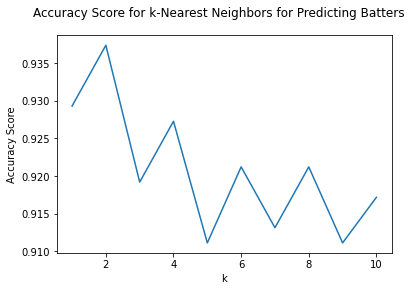

In [39]:
#In this code cell, we will find the optimal k value to use

accuracy_score_list = []
k_list = []

for k in range(1, 11):
    k_list.append(k)
    y_feat = 'HOF'

    df_b_scaled = pd.DataFrame()

    # scale normalization (overwrites old data)
    for feat in x_feat_list_b:
        df_b_scaled[feat] = df_b[feat] / df_b[feat].std()

    # extract data into numpy format (for sklearn)
    x = df_b_scaled.loc[:, x_feat_list_b].values
    y_true = df_b.loc[:, y_feat].values

    # initialize a knn_classifier
    knn_classifier_b = KNeighborsClassifier(n_neighbors=k)

    # construction of kfold object
    kfold = StratifiedKFold(n_splits=10) # the k-folds

    # allocate an empty array to store predictions in
    y_pred = copy(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]
    
        # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
        knn_classifier_b.fit(x_train, y_true_train)

        # estimate each pokemon's maintype
        y_pred[test_idx] = knn_classifier_b.predict(x_test)

    accuracy_score_list.append(accuracy_score(y_true, y_pred))



plt.plot(k_list, accuracy_score_list)
plt.suptitle('Accuracy Score for k-Nearest Neighbors for Predicting Batters')
plt.xlabel('k')
plt.ylabel('Accuracy Score')

Per the above graph, we will choose a k-value of 2 since it produces the highest accuracy score.

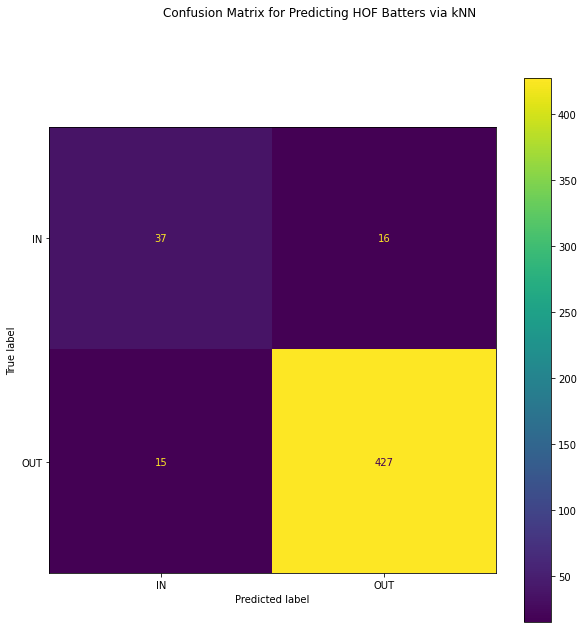

In [40]:
k = 2 # the k-nearest neighbors
y_feat = 'HOF'

df_b_scaled = pd.DataFrame()

# scale normalization (overwrites old data)
for feat in x_feat_list_b:
    df_b[feat].std()
    df_b_scaled[feat] = df_b[feat] / df_b[feat].std()
    

# extract data into numpy format (for sklearn)
x = df_b_scaled.loc[:, x_feat_list_b].values
y_true = df_b.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier_b = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = StratifiedKFold(n_splits=10) # the k-folds

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier_b.fit(x_train, y_true_train)

    # estimate each pokemon's maintype
    y_pred[test_idx] = knn_classifier_b.predict(x_test)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
conf_mat_disp.plot()

plt.gcf().set_size_inches(10, 10)
plt.suptitle('Confusion Matrix for Predicting HOF Batters via kNN')

# seaborn turns on grid by default ... looks best without it
plt.grid(False)

In [41]:
print("(accuracy, sensitivity, specificity): " + str(get_acc_sens_spec(y_true, y_pred, conf_mat)))

(accuracy, sensitivity, specificity): (0.9373737373737374, 0.9660633484162896, 0.963882618510158)


Per the above Confusion Matrix, we see that we are very good at predicting Non-HOF batters, but not as good at predicting HOF batters. Because of this and the fact most of the batters in our dataset are Non-HOF players, we have very high accuracy, sensitivity, and specificity scores.

## K-Nearest Neighbors for Pitchers
<a id='KNN-pit'></a>

In [42]:
#For pitchers

#Deletes unnecessary columns
del df_p['Awards']
del df_p['Pos']

#Get the x features we want
x_feat_list_p = list(df_p.columns)[5:-4]

for row_idx in range(0, df_p.shape[0]):
    if df_p.loc[row_idx, 'HOF'] == 1:
        df_p.loc[row_idx, 'HOF'] = 'IN'
    if df_p.loc[row_idx, 'HOF'] == 0:
        df_p.loc[row_idx, 'HOF'] = 'OUT'

df_p

,Unnamed: 0,Year,Age,Tm,Lg,W,L,W-L%,ERA,G,...,SO/W,MVP,CYA,AS,GG,SS,Player,Unnamed: 35,HOF,Unnamed: 0.1
0,24,16 Yrs,16 Yrs,16 Yrs,16 Yrs,203.0,105.0,0.659,3.38,416.0,...,3.58,0,2,8,0,0,Roy Halladay,NaN,IN,NaN
1,22,18 Yrs,18 Yrs,18 Yrs,18 Yrs,270.0,153.0,0.638,3.68,537.0,...,3.58,0,0,5,7,0,Mike Mussina,NaN,IN,NaN
2,26,19 Yrs,19 Yrs,19 Yrs,19 Yrs,82.0,60.0,0.577,2.21,1115.0,...,4.10,0,0,13,0,0,Mariano Rivera,NaN,IN,NaN
3,24,18 Yrs,18 Yrs,18 Yrs,18 Yrs,61.0,75.0,0.449,2.87,1035.0,...,3.69,0,0,7,0,0,Trevor Hoffman,NaN,IN,NaN
4,35,22 Yrs,22 Yrs,22 Yrs,22 Yrs,303.0,166.0,0.646,3.29,618.0,...,3.26,0,5,10,0,0,Randy Johnson,NaN,IN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,22,13 Yrs,13 Yrs,13 Yrs,13 Yrs,153.0,131.0,0.539,3.75,391.0,...,4.03,0,0,3,0,0,Dan Haren,NaN,OUT,NaN
255,31,16 Yrs,16 Yrs,16 Yrs,16 Yrs,64.0,34.0,0.653,2.87,787.0,...,2.84,0,0,6,0,0,Joe Nathan,NaN,OUT,NaN
256,14,10 Yrs,10 Yrs,10 Yrs,10 Yrs,110.0,89.0,0.553,3.74,278.0,...,2.59,0,2,4,0,0,Tim Lincecum,NaN,OUT,NaN
257,18,12 Yrs,12 Yrs,12 Yrs,12 Yrs,41.0,36.0,0.532,2.44,689.0,...,4.37,0,0,6,0,0,Jonathan Papelbon,NaN,OUT,NaN


Text(0, 0.5, 'Accuracy Score')

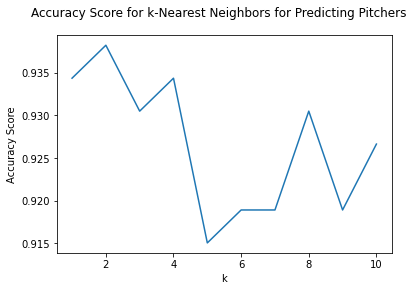

In [43]:
accuracy_score_list = []
k_list = []

for k in range(1, 11):
    k_list.append(k)
    y_feat = 'HOF'

    df_p_scaled = pd.DataFrame()

    # scale normalization (overwrites old data)
    for feat in x_feat_list_p:
        df_p_scaled[feat] = df_p[feat] / df_p[feat].std()

    # extract data into numpy format (for sklearn)
    x = df_p_scaled.loc[:, x_feat_list_p].values
    y_true = df_p.loc[:, y_feat].values

    # initialize a knn_classifier
    knn_classifier_p = KNeighborsClassifier(n_neighbors=k)

    # construction of kfold object
    kfold = StratifiedKFold(n_splits=10) # the k-folds

    # allocate an empty array to store predictions in
    y_pred = copy(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]
    
        # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
        knn_classifier_p.fit(x_train, y_true_train)

        # estimate each pokemon's maintype
        y_pred[test_idx] = knn_classifier_p.predict(x_test)

    accuracy_score_list.append(accuracy_score(y_true, y_pred))



plt.plot(k_list, accuracy_score_list)
plt.suptitle('Accuracy Score for k-Nearest Neighbors for Predicting Pitchers')
plt.xlabel('k')
plt.ylabel('Accuracy Score')

Per the above graph, we will choose a k-value of 2 since it produces the highest accuracy score.

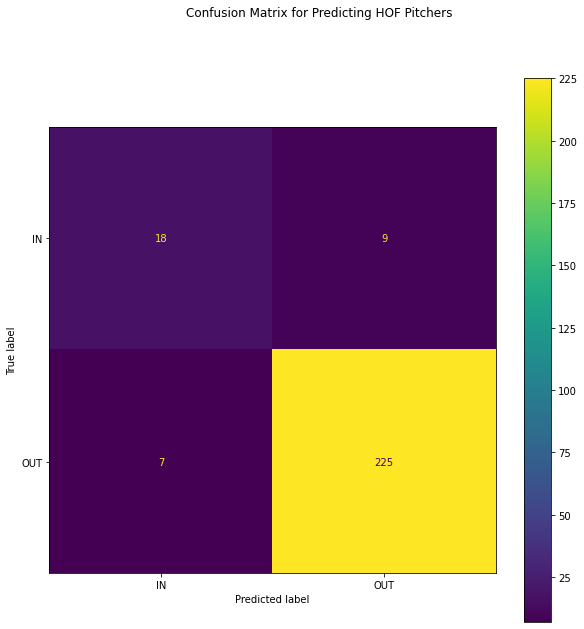

In [44]:
k = 2 # the k-nearest neighbors
y_feat = 'HOF'

df_p_scaled = pd.DataFrame()

# scale normalization (overwrites old data)
for feat in x_feat_list_p:
    df_p[feat].std()
    df_p_scaled[feat] = df_p[feat] / df_p[feat].std()
    

# extract data into numpy format (for sklearn)
x = df_p_scaled.loc[:, x_feat_list_p].values
y_true = df_p.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier_p = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = StratifiedKFold(n_splits=10) # the k-folds

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier_p.fit(x_train, y_true_train)

    # estimate each pokemon's maintype
    y_pred[test_idx] = knn_classifier_p.predict(x_test)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
conf_mat_disp.plot()

plt.gcf().set_size_inches(10, 10)
plt.suptitle('Confusion Matrix for Predicting HOF Pitchers')

# seaborn turns on grid by default ... looks best without it
plt.grid(False)

In [45]:
print("(accuracy, sensitivity, specificity): " + str(get_acc_sens_spec(y_true, y_pred, conf_mat)))

(accuracy, sensitivity, specificity): (0.9382239382239382, 0.9698275862068966, 0.9615384615384616)


Per the above Confusion Matrix, we see that we are very good at predicting Non-HOF pitchers, but not as good at predicting HOF pitchers. Because of this and the fact most of the pitchers in our dataset are Non-HOF players, we have very high accuracy, sensitivity, and specificity scores.

## Random Forest for Batters
<a id='RF-bat'></a>

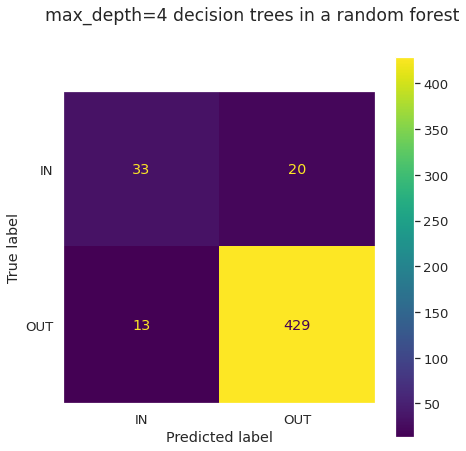

In [197]:
x = df_b.loc[:, x_feat_list_b].values
y = df_b.loc[:, y_feat].values

n_splits = 10
max_depth = 4

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# initialize random forest
rf_clf_b = RandomForestClassifier(max_depth=max_depth, n_estimators=1000)

# initialize y_pred, stores predictions of y
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    rf_clf_b = rf_clf_b.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = rf_clf_b.predict(x_test)

y_feat_list = np.array(["IN", "OUT"])

# build and plot confusion matrix
sns.set(font_scale=1.2)
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=y_feat_list)
conf_mat_disp.plot()
plt.gcf().set_size_inches(7, 7)
plt.grid(False)
plt.suptitle('max_depth=4 decision trees in a random forest');

In [198]:
print("(accuracy, sensitivity, specificity): " + str(get_acc_sens_spec(y, y_pred, conf_mat)))

(accuracy, sensitivity, specificity): (0.9333333333333333, 0.9705882352941176, 0.955456570155902)


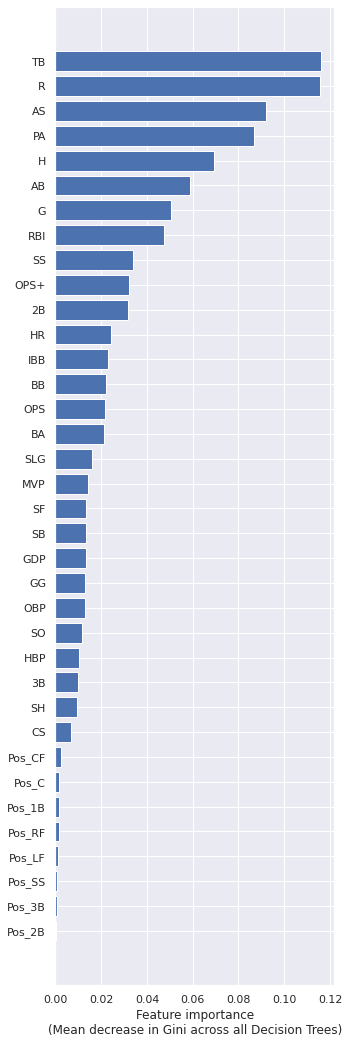

In [175]:
sns.set()

plot_feat_import(x_feat_list_b, rf_clf_b.feature_importances_, limit=70)

## Random Forest for Pitchers
<a id='RF-pit'></a>

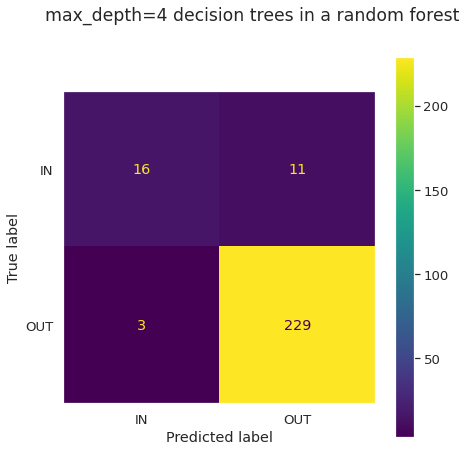

In [195]:
x = df_p.loc[:, x_feat_list_p].values
y = df_p.loc[:, y_feat].values

n_splits = 10
max_depth = 4

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# initialize random forest
rf_clf_p = RandomForestClassifier(max_depth=max_depth, n_estimators=1000)

# initialize y_pred, stores predictions of y
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    rf_clf_p = rf_clf_p.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = rf_clf_p.predict(x_test)

y_feat_list = np.array(["IN", "OUT"])

# build and plot confusion matrix
sns.set(font_scale=1.2)
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=y_feat_list)
conf_mat_disp.plot()
plt.gcf().set_size_inches(7, 7)
plt.grid(False)
plt.suptitle('max_depth=4 decision trees in a random forest');

In [196]:

print("(accuracy, sensitivity, specificity): " + str(get_acc_sens_spec(y, y_pred, conf_mat))) 

(accuracy, sensitivity, specificity): (0.9459459459459459, 0.9870689655172413, 0.9541666666666667)


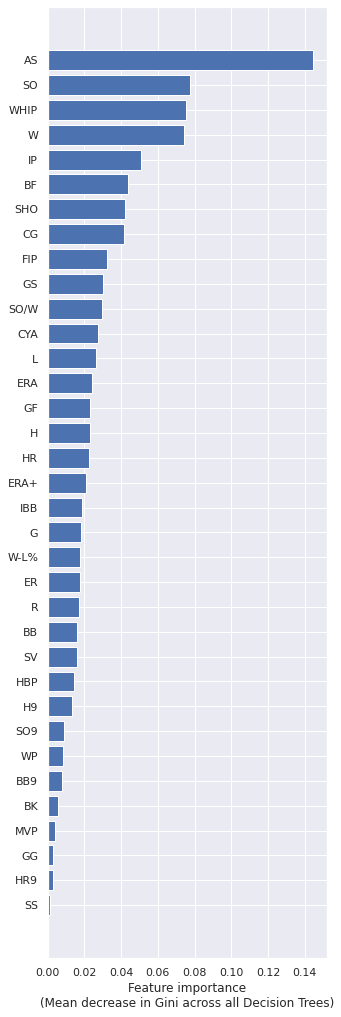

In [178]:
sns.set()

plot_feat_import(x_feat_list_p, rf_clf_p.feature_importances_, limit=70)

# Predictions:
<a id='pred'></a>

Using the statistics of retired players who are eligible for the Hall of Fame in the next 5 years, we will predict if they will reach the Hall of Fame or not using our models.

## Predicting New Batters Hall of Fame Chances using kNN

In [182]:

#Scale Normalization
df_nominees_b_scaled = copy(df_nominees_b)
for feat in x_feat_list_b:
    df_nominees_b_scaled[feat] = df_nominees_b_scaled[feat] / df_nominees_b_scaled[feat].std()

#Create kNN fitted whole historical dataset
#Don't need to cross validate since we will be predicting on new data

k = 2 # the k-nearest neighbors
y_feat = 'HOF'
df_b_scaled = pd.DataFrame()
# scale normalization (overwrites old data)
for feat in x_feat_list_b:
    if df_b[feat].std() == 0:
        df_b_scaled[feat] = df_b[feat]
    else:
        df_b_scaled[feat] = df_b[feat] / df_b[feat].std()
# extract data into numpy format (for sklearn)
x = df_b_scaled.loc[:, x_feat_list_b].values
y_true = df_b.loc[:, y_feat].values
# initialize a knn_classifier
knn_classifier_b = KNeighborsClassifier(n_neighbors=k)
#Fits classifier on data
knn_classifier_b.fit(x, y_true)


#Prediction

x_new_b = df_nominees_b_scaled.loc[:, x_feat_list_b].values

y_new_b_pred = knn_classifier_b.predict(x_new_b)

df_nominees_b['HOF Pred'] = y_new_b_pred

prediction_dict_b = {}
for row_idx in range(0, df_nominees_b.shape[0]):
    player = df_nominees_b.iloc[row_idx, 32]
    prediction = df_nominees_b.iloc[row_idx, -1]
    prediction_dict_b[player] = prediction

prediction_dict_b

{'Carlos Beltran': 'IN',
 'Jacoby Ellsbury': 'IN',
 'Jhonny Peralta': 'OUT',
 'Jayson Werth': 'OUT',
 'J.J. Hardy': 'OUT',
 'Mike Napoli': 'OUT',
 'Andre Ethier': 'IN',
 'Adrian Beltre': 'IN',
 'Chase Utley': 'IN',
 'Joe Mauer': 'IN',
 'David Wright': 'IN',
 'Matt Holliday': 'IN',
 'Adrian Gonzalez': 'IN',
 'Jose Reyes': 'IN',
 'Jose Bautista': 'IN',
 'Victor Martinez': 'IN',
 'Brandon Phillips': 'IN',
 'Denard Span': 'IN',
 'Chase Headley': 'IN',
 'Colby Rasmus': 'OUT',
 'Dustin Pedroia': 'IN',
 'Troy Tulowitzki': 'OUT',
 'Ichiro Suzuki': 'IN',
 'Brian McCann': 'IN',
 'Ben Zobrist': 'OUT',
 'Russell Martin': 'OUT',
 'Curtis Granderson': 'IN',
 'Martin Prado': 'IN',
 'Carlos Gomez': 'OUT',
 'Melky Cabrera': 'OUT',
 'Ian Kinsler': 'IN',
 'Chris Davis': 'OUT',
 'Alex Gordon': 'IN',
 'Nick Markakis': 'IN',
 'Daniel Murphy': 'OUT',
 'Ryan Braun': 'IN',
 'Hunter Pence': 'IN',
 'Howie Kendrick': 'OUT',
 'Kyle Seager': 'OUT',
 'Josh Reddick': 'OUT',
 'Todd Frazier': 'OUT',
 'Buster Posey': 'I

## Predicting New Pitchers Hall of Fame Chances using kNN

In [185]:

#Scale Normalization
df_nominees_p_scaled = copy(df_nominees_p)
for feat in x_feat_list_p:
    if df_nominees_p_scaled[feat].std() == 0:
        df_nominees_p_scaled[feat] = df_nominees_p_scaled[feat]
    else:
        df_nominees_p_scaled[feat] = df_nominees_p_scaled[feat] / df_nominees_p_scaled[feat].std()

#Create kNN fitted whole historical dataset
#Don't need to cross validate since we will be predicting on new data

k = 2 # the k-nearest neighbors
y_feat = 'HOF'
df_p_scaled = pd.DataFrame()
# scale normalization (overwrites old data)
for feat in x_feat_list_p:
    if df_p[feat].std() == 0:
        df_p_scaled[feat] = df_p[feat]
    else:
        df_p_scaled[feat] = df_p[feat] / df_p[feat].std()
# extract data into numpy format (for sklearn)
x = df_p_scaled.loc[:, x_feat_list_p].values
y_true = df_p.loc[:, y_feat].values
# initialize a knn_classifier
knn_classifier_p = KNeighborsClassifier(n_neighbors=k)
#Fits classifier on data
knn_classifier_p.fit(x, y_true)


#Prediction

x_new_p = df_nominees_p_scaled.loc[:, x_feat_list_p].values

y_new_p_pred = knn_classifier_p.predict(x_new_p)

df_nominees_p['HOF Pred'] = y_new_p_pred

prediction_dict_p = {}
for row_idx in range(0, df_nominees_p.shape[0]):
    player = df_nominees_p.iloc[row_idx, -2]
    prediction = df_nominees_p.iloc[row_idx, -1]
    prediction_dict_p[player] = prediction

prediction_dict_p

{'John Lackey': 'OUT',
 'Jered Weaver': 'OUT',
 'Matt Cain': 'OUT',
 'Bronson Arroyo': 'OUT',
 'R.A. Dickey': 'OUT',
 'Huston Street': 'OUT',
 'CC Sabathia': 'IN',
 'Gio Gonzalez': 'OUT',
 'Jordan Zimmermann': 'OUT',
 'Jake Arrieta': 'OUT',
 'J.A. Happ': 'OUT',
 'Jon Lester': 'OUT'}

## Predicting New Batters Hall of Fame Chances using Random Forests

In [191]:
x = df_nominees_b.loc[:, x_feat_list_b].values
rf_b_y_pred = rf_clf_b.predict(x)

rf_b_y_pred

prediction_dict_b = {}
for row_idx in range(0, df_nominees_b.shape[0]):
    player = df_nominees_b.iloc[row_idx, 32]
    prediction = rf_b_y_pred[row_idx]
    prediction_dict_b[player] = prediction

prediction_dict_b

{'Carlos Beltran': 'IN',
 'Jacoby Ellsbury': 'OUT',
 'Jhonny Peralta': 'OUT',
 'Jayson Werth': 'OUT',
 'J.J. Hardy': 'OUT',
 'Mike Napoli': 'OUT',
 'Andre Ethier': 'OUT',
 'Adrian Beltre': 'IN',
 'Chase Utley': 'OUT',
 'Joe Mauer': 'OUT',
 'David Wright': 'OUT',
 'Matt Holliday': 'OUT',
 'Adrian Gonzalez': 'OUT',
 'Jose Reyes': 'OUT',
 'Jose Bautista': 'OUT',
 'Victor Martinez': 'OUT',
 'Brandon Phillips': 'OUT',
 'Denard Span': 'OUT',
 'Chase Headley': 'OUT',
 'Colby Rasmus': 'OUT',
 'Dustin Pedroia': 'OUT',
 'Troy Tulowitzki': 'OUT',
 'Ichiro Suzuki': 'IN',
 'Brian McCann': 'OUT',
 'Ben Zobrist': 'OUT',
 'Russell Martin': 'OUT',
 'Curtis Granderson': 'OUT',
 'Martin Prado': 'OUT',
 'Carlos Gomez': 'OUT',
 'Melky Cabrera': 'OUT',
 'Ian Kinsler': 'OUT',
 'Chris Davis': 'OUT',
 'Alex Gordon': 'OUT',
 'Nick Markakis': 'OUT',
 'Daniel Murphy': 'OUT',
 'Ryan Braun': 'OUT',
 'Hunter Pence': 'OUT',
 'Howie Kendrick': 'OUT',
 'Kyle Seager': 'OUT',
 'Josh Reddick': 'OUT',
 'Todd Frazier': 'OUT

## Predicting New Pitchers Hall of Fame Chances using Random Forests

In [193]:
x = df_nominees_p.loc[:, x_feat_list_p].values
rf_p_y_pred = rf_clf_p.predict(x)

prediction_dict_p = {}
for row_idx in range(0, df_nominees_p.shape[0]):
    player = df_nominees_p.iloc[row_idx, -2]
    prediction = rf_p_y_pred[idx]
    prediction_dict_p[player] = prediction

prediction_dict_p

{'John Lackey': 'OUT',
 'Jered Weaver': 'OUT',
 'Matt Cain': 'OUT',
 'Bronson Arroyo': 'OUT',
 'R.A. Dickey': 'OUT',
 'Huston Street': 'OUT',
 'CC Sabathia': 'OUT',
 'Gio Gonzalez': 'OUT',
 'Jordan Zimmermann': 'OUT',
 'Jake Arrieta': 'OUT',
 'J.A. Happ': 'OUT',
 'Jon Lester': 'OUT'}

# Results:
<a id='results'></a>

The confusion matrices and graph above show our results. The confusion matrix shows the results from each of the classifiers (how many it predicted correctly versus how many it predicted incorrectly for both players in the Hall of Fame and not). 
- [k nearest neighbor for pitches](#KNN-pit)
- [k nearest neighbor for batters](#KNN-bat)
-  [Random Forest for pitches](#RF-bat)
-  [Random Forest for batters](#RF-pit)


In addition to the confusion matrix for each result our random forest model also allows us to see feature importance for both batters and pitchers. The bar plot under the random forest models shows which features are most important in descending order (the most important feature is at the top). We discovered that for the batters the most important features included runs scored, total bases, and all-star appearances while for pitchers the most important features were all-star appearances, WHIP, and wins. 


# Discussion:

The KNN and Random Forest models both provided favorable results in predicting whether or not players would make the Hall of Fame. Our results showed that the specificity of the models was much better than the sensitivity. It proved to be much harder to predict if players would make the Hall of Fame versus players that wouldn't, and this could be due to several factors. One reason may be that many more players do not make the Hall of Fame than players that do, so we have a much larger sample size of data to use on players who did not make the Hall of Fame, so it is easier to predict that they did not make it. Because of this, we had a sensitivity value of about 62% versus a specificity value of about 97%, making our accuracy about 93% (which is a bit skewed because of how much more data exists with players who have not made the Hall of Fame). Overall, we are happy with the quality of our results. 

Another reason why it may be harder to predict which players got into the Hall of Fame compared to which players didn't (which is shown by our low sensitivity) is because while there may be a barrier of stats and awards that players must reach to get in, breaking that barrier does not guarantee entry. The Hall of Fame is voted on by different writers who have different perspectives and therefore there is a lot of subjectiveness that goes into the decision-making process. Because of this, outside factors such as a player's personality may play a significant role in whether a player gets inducted or not. What our results show is that because stats alone cannot predict perfectly which players make the Hall of Fame, the narrative surrounding a player's career and how they are viewed by the public also has a role in either pushing them over the edge or holding them back. 

Another aspect of our results is that we calculated pitchers and batters differently, which allowed us to test if stats and awards have different levels of significance for each type of player. What we found was that the results were very similar for both groups with the sensitivity being low for both types of players and falling within three percent of each other, while the total accuracy stayed around the same level. From this, we can conclude that stats and awards matter just as much for hitters as they do pitchers in determining if they make the Hall of Fame. 

In addition to this, we also made predictions on retired players who will be eligible for the Hall of Fame ballot within the next 5 years. Using both models, we predicted which players would make the Hall of Fame and who wouldn't. To our surprise, even though both of our models had very similar accuracy scores when cross validating on historical data, when predicting on this new data, they produced different results. Our KNN model ended up predicting more players entering the Hall of Fame than our Random Forest model, and using our general baseball knowledge, we identified our Random Forest model as better at predicting this future data. This is because in KNN, all features are given the same weight, while in Random Forest (which used the same features), some features are weighted more than others. KNN will treat features A and B the same even if in Random Forest, feature A is found to be very important and feature B is found to be unnecessary. As a result, Random Forest is better at predicting a player's Hall of Fame induction.


This project was able to show us that while we can predict a player getting into the Hall of Fame with solid accuracy, but there are still other factors that must play a role in the decision to induct someone. If we were to expand this proejct we could look at data such as the amount of teams a player played for, how much money they made in their career, and potentially find ways to quantify the public's perception of them. Using these new features, we may be able to make a more accurate model for predicting whether a player will make the Hall of Fame.